In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import cv2 as cv

In [2]:
src = Path("./data/extracted_imgs/sd1_sample/")
dst = Path("./data/annotations") / src.parts[-1]
# dst.mkdir()

In [3]:
imgs = sorted(list(src.iterdir()))

In [4]:
def random_show(imgs: list, N: int = 4) -> None:
    idx = np.random.choice(len(imgs), size=N, replace=False)
    _, ax = plt.subplots(
        int(np.ceil(N // 4)), 4, figsize=(16, 6), tight_layout=True, sharey=True
    )
    ax = ax.flatten()
    for n in range(N):
        img = cv.imread(str(imgs[idx[n]]))
        ax[n].imshow(img)
        ax[n].set_title(imgs[idx[n]].parts[-1])
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

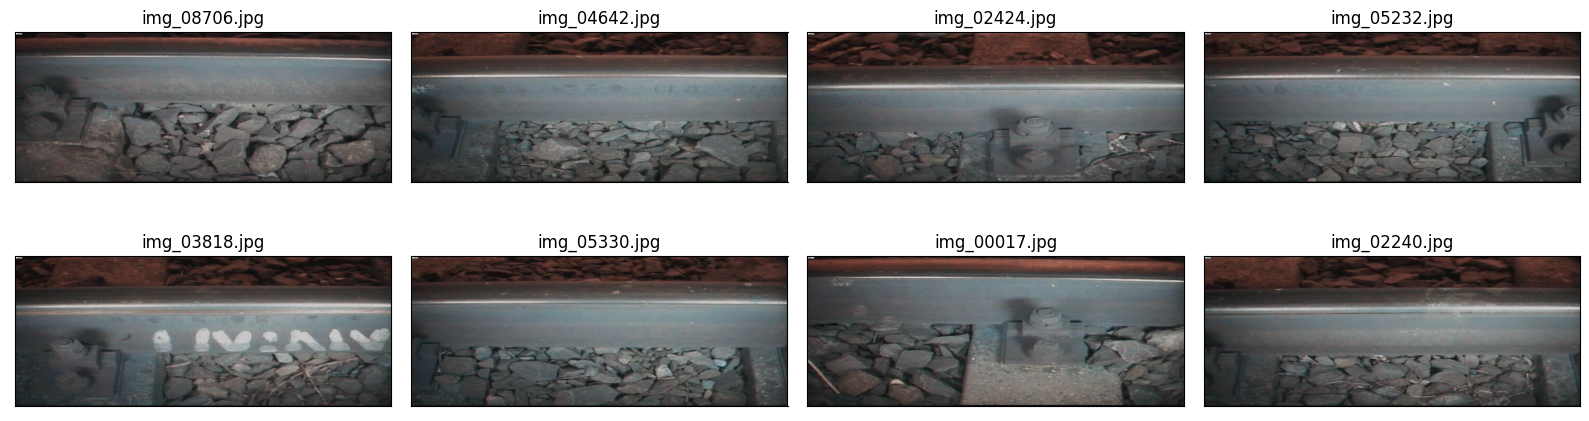

In [5]:
random_show(imgs, 8)

In [25]:
def image_manipulator(img: np.ndarray, plot: bool=True) -> tuple[np.ndarray, np.ndarray]:
    img_raw = cv.imread(str(img))
    img     = cv.cvtColor(img_raw, cv.COLOR_BGR2GRAY)
    clahe   = cv.createCLAHE()
    img_mod = clahe.apply(img)
    img_mod = cv.Sobel(img_mod, cv.CV_8U, 0, 1, ksize=11)

    if plot:
        _, axs = plt.subplots(1, 2, figsize=(16, 4), tight_layout=True, sharey=True)
        axs[0].imshow(img_raw)
        axs[1].imshow(img_mod, cmap='gray')
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    return img, img_mod

In [26]:

def marginal_histograms(img: np.ndarray, img_mod: np.ndarray) -> None:
    mean_1 = np.mean(img_mod, axis=0)
    mean_2 = np.mean(img_mod, axis=1)
    std_1 = np.std(img_mod, axis=0)
    std_2 = np.std(img_mod, axis=1)
    x1 = np.arange(len(mean_1))
    x2 = np.arange(len(mean_2))

    fig = plt.figure(figsize=(10, 6), tight_layout=True)

    gs = GridSpec(nrows=2, ncols=2, figure=fig, width_ratios=[3, 1], height_ratios=[1, 3])

    ax0 = fig.add_subplot(gs[1, 0])
    ax1 = fig.add_subplot(gs[0, 0], sharex=ax0)
    ax2 = fig.add_subplot(gs[1, 1], sharey=ax0)

    ax0.imshow(img, aspect='auto', cmap="gray")
    ax1.plot(x1, mean_1)
    ax1.plot(x1, std_1)
    ax2.plot(mean_2, x2)
    ax2.plot(std_2, x2)
    ax2.vlines([np.mean(mean_2)], ymin=x2[0], ymax=x2[-1], colors='red')

    plt.show()

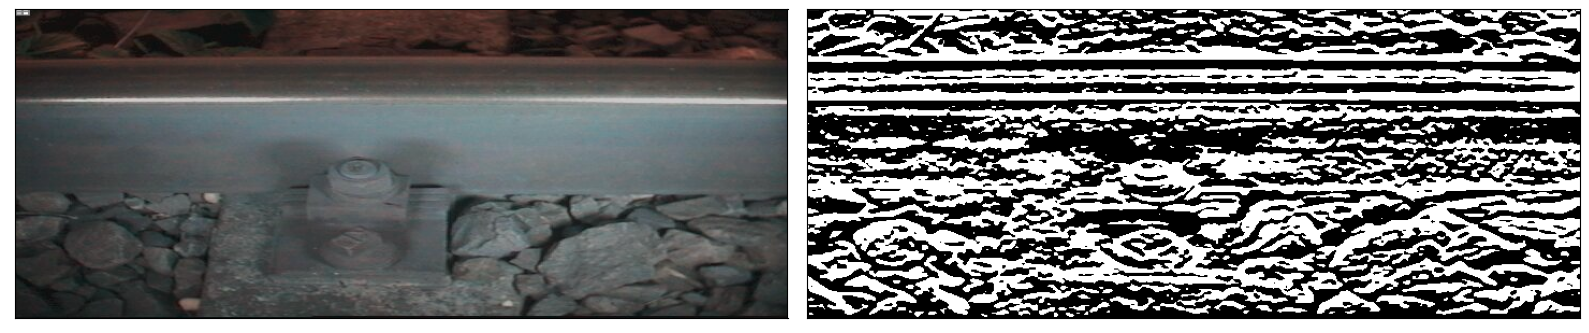

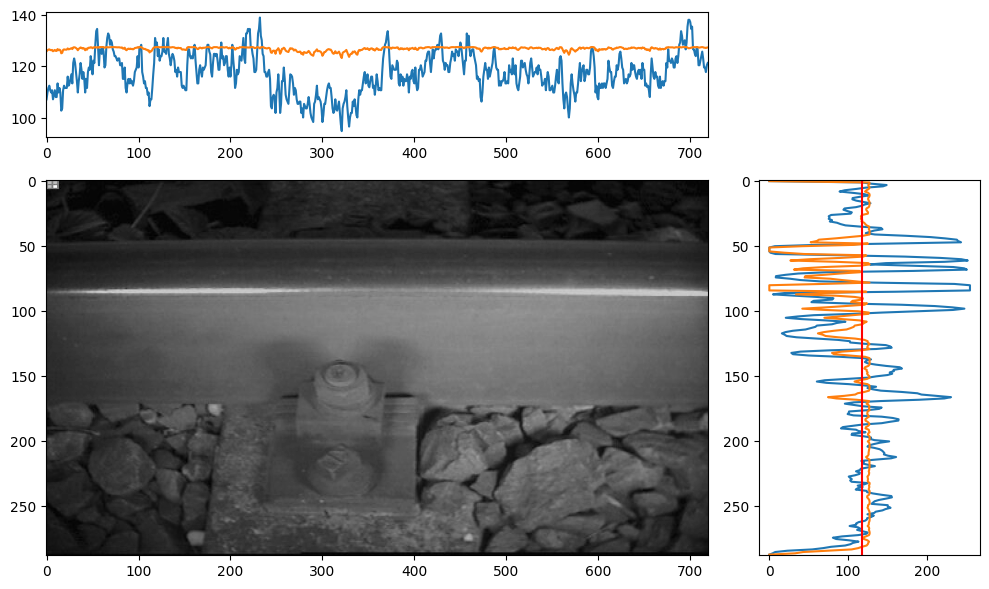

In [27]:
img, img_mod = image_manipulator(imgs[np.random.choice(len(imgs))])
marginal_histograms(img, img_mod)